### Vorticity balance in the North Alantic Ocean

This notebook is for analyzing depth-integrated vorticity budget terms in the North Atlantic region. The intent is to understand the main balances in this region in a hirarchy of model resolutions.

In a non steady state, the following balance holds

\begin{equation}
\beta \overline{\int_{-H}^{\eta}vdz} = \dfrac{1}{\rho_o}\overline{J(p_b, H)} - \overline{\dfrac{fQ_m}{\rho_o}} + f\partial_t\eta - \nabla \wedge \int_{-H}^{\eta} \mathbf{u}dz + \dfrac{1}{\rho_o}\nabla \wedge\overline{\left(\boldsymbol{\tau_s - \tau_b}\right)} + \overline{\nabla \wedge \int_{-H}^{\eta}\mathbf{a}dz} + \overline{\nabla \wedge \int_{-H}^{\eta}\mathbf{b}dz} \tag{1}
\end{equation}

\begin{equation}
\beta \overline{V} = \dfrac{1}{\rho_o}\overline{J(p_b, H)} - f\overline{\dfrac{Q_m}{\rho_o}} + f\partial_t\eta - \nabla \wedge \mathcal{U}_t + \dfrac{1}{\rho_o}\nabla \wedge\overline{\left(\boldsymbol{\tau_s - \tau_b}\right)} + \overline{\nabla \wedge \mathcal{A}} + \overline{\nabla \wedge \mathcal{B}} \tag{2}
\end{equation}

It is seen that, in addition to boundary stress terms (fifth term on the RHS), bottom pressure torque (first term on the RHS) and nonlinear terms (sixth term on the RHS) do contribute significantly to the overall vorticity baalnce. Here, we isolate the relative contributions of these terms in 1/8 deg MOM6 simulation.

In order to compute bottom pressure torque, we use the following relation (the terms on the RHS are available as diagnostics)

\begin{equation}
\dfrac{1}{\rho_o}\overline{J(p_b, H)} = \nabla \wedge\left[- f \hat{{\bf z}} \wedge \int_{-H}^{\eta} \mathbf{u}dz - \frac{1}{\rho_o}\int_{-H}^{\eta} \nabla pdz \right] + \beta \overline{V} + f\overline{\dfrac{Q_m}{\rho_o}} - f\partial_t\eta \tag{3}
\end{equation}

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [3]:
# Filter set

def apply_gaussian_filter(field,wetMask,NL_g,sL_g,NB_g,sB_g):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

def apply_taper_filter(field,wetMask,NL_t,sL_t,NB_t,sB_t):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_t):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_t[i])*tempL # Update filtered field
    for i in range(NB_t): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_t[i])/np.abs(sB_t[i])**2)*tempL + (1/np.abs(sB_t[i])**2)*tempB
        
    return fieldBar

def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

# Laplacian steps: 16; # Biharmonic steps: 2


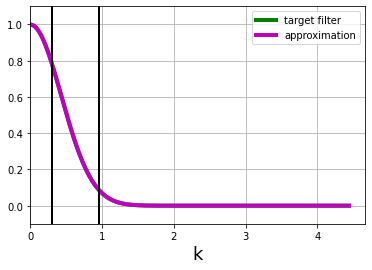

In [4]:
# Set Filter

# Guassian Filter set 

filter_fac = 8 # 1/8 --> 1 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 20
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

In [5]:
# Read data

ds = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Global_MOM6/v3/Mom_Budget_OM125_011601-012012.nc")

ds = ds.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

print(ds)

<xarray.Dataset>
Dimensions:             (xh: 835, xq: 835, yh: 964, yq: 964)
Coordinates:
  * xh                  (xh) float64 -99.93 -99.78 -99.63 ... 9.657 9.773 9.888
  * yh                  (yh) float64 0.0 0.125 0.25 0.375 ... 79.84 79.89 79.95
  * xq                  (xq) float64 -100.0 -99.85 -99.7 ... 9.657 9.773 9.888
  * yq                  (yq) float64 0.0625 0.1875 0.3125 ... 79.86 79.92 79.97
Data variables:
    hf_CAu_2d           (yh, xq) float64 ...
    hf_CAv_2d           (yq, xh) float64 ...
    hf_PFu_2d           (yh, xq) float64 ...
    hf_PFv_2d           (yq, xh) float64 ...
    hf_diffu_2d         (yh, xq) float64 ...
    hf_diffv_2d         (yq, xh) float64 ...
    hf_du_dt_visc_2d    (yh, xq) float64 ...
    hf_dudt_2d          (yh, xq) float64 ...
    hf_dv_dt_visc_2d    (yq, xh) float64 ...
    hf_dvdt_2d          (yq, xh) float64 ...
    hf_gKEu_2d          (yh, xq) float64 ...
    hf_gKEv_2d          (yq, xh) float64 ...
    hf_rvxu_2d          (yq, xh) f

In [6]:
# Double precision static file

ppdir = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_f8static/gfdl.ncrc4-intel18-prod-openmp/history/"
ds_grid = xr.open_dataset(ppdir + "01010101.ocean_static.nc")

ds_grid = ds_grid.isel(xq = slice(0,2880), yq=slice(0,2240))

ds_grid = ds_grid.drop('time')

ds_grid = ds_grid.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

In [7]:
print(ds_grid)

<xarray.Dataset>
Dimensions:       (xh: 835, xq: 835, yh: 964, yq: 964)
Coordinates:
  * xh            (xh) float64 -99.93 -99.78 -99.63 -99.48 ... 9.657 9.773 9.888
  * yh            (yh) float64 0.0 0.125 0.25 0.375 ... 79.78 79.84 79.89 79.95
  * xq            (xq) float64 -100.0 -99.85 -99.7 -99.55 ... 9.657 9.773 9.888
  * yq            (yq) float64 0.0625 0.1875 0.3125 0.4375 ... 79.86 79.92 79.97
Data variables:
    areacello     (yh, xh) float64 ...
    deptho        (yh, xh) float64 ...
    hfgeou        (yh, xh) float64 ...
    sftof         (yh, xh) float64 ...
    Coriolis      (yq, xq) float64 ...
    geolon        (yh, xh) float64 ...
    geolat        (yh, xh) float64 ...
    geolon_c      (yq, xq) float64 ...
    geolat_c      (yq, xq) float64 ...
    geolon_u      (yh, xq) float64 ...
    geolat_u      (yh, xq) float64 ...
    geolon_v      (yq, xh) float64 ...
    geolat_v      (yq, xh) float64 ...
    wet           (yh, xh) float64 ...
    wet_c         (yq, xq) floa

In [8]:
print(np.finfo(ds.intz_CAu_2d))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [15]:
print(np.finfo(ds_grid.dxCu))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [48]:
print(np.finfo(ds.dxCu))

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------



#### Compute depth, beta at u, v points

In [10]:
# Create grid and interpolate depth, beta

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

depth_u = grid.interp(ds['deptho'] * ds_grid['areacello'], 'X',  boundary='fill')  / ds_grid['areacello_cu']
depth_v = grid.interp(ds['deptho'] * ds_grid['areacello'], 'Y',  boundary='fill') / ds_grid['areacello_cv']
depth_q = grid.interp(depth_u * ds_grid['areacello_cu'], 'Y',  boundary='fill') / ds_grid['areacello_bu']

colh_u = grid.interp(ds['col_height'] * ds_grid['areacello'], 'X',  boundary='fill') / ds_grid['areacello_cu']
colh_v = grid.interp(ds['col_height'] * ds_grid['areacello'], 'Y',  boundary='fill') / ds_grid['areacello_cv']

#beta_u =  grid.diff(ds['Coriolis'], 'Y',  boundary='fill') / ds_grid['dyCu']
#beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

beta_v = 2*OMEGA*np.cos(ds.geolat_v * np.pi /180.)/RAD_EARTH
beta_q = 2*OMEGA*np.cos(ds.geolat_c * np.pi /180.)/RAD_EARTH

#### Compute terms in vorticity budget

In [11]:
rho_0 = 1035.

BPT = xr.Dataset()

vmo_bv = (ds['vmo'] / (rho_0 * ds_grid['dxCv'])).load()
vmo_bv = beta_q * grid.interp(vmo_bv, 'X',  boundary='fill')

vmo_bv = vmo_bv.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT_1 = ( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds_grid.dyCv, 'X', boundary='fill') 
          ) / ds_grid.areacello_bu

%time BPT['BPT'] = (BPT_1.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

%time BPT['vmo_bv'] = (vmo_bv.load())

%time BPT['depth'] = (depth_q.load())

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.19 ms
CPU times: user 2 ms, sys: 5 ms, total: 7 ms
Wall time: 102 ms
CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 1.08 ms


In [23]:
# Compute BPT with double precision static file

BPT_2 = ( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds_grid.dyCv, 'X', boundary='fill') 
          ) / ds_grid.areacello_bu

BPT_2 = BPT_2.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [33]:
print(np.finfo(BPT_2))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



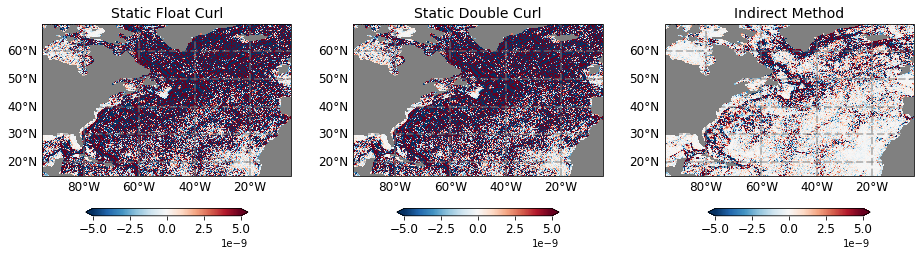

In [39]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[16,4])

BPT1 = BPT['BPT'] + BPT['Curl_Cor'] + BPT['vmo_bv'] + BPT['Qm']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Static Float Curl')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_2, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Static Double Curl')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Indirect Method')

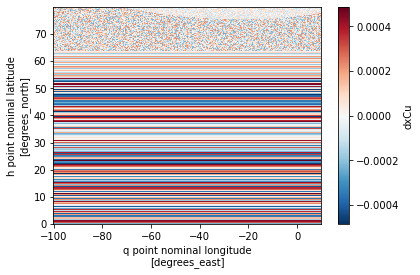

In [42]:
(ds_grid.dxCu - ds.dxCu).plot()

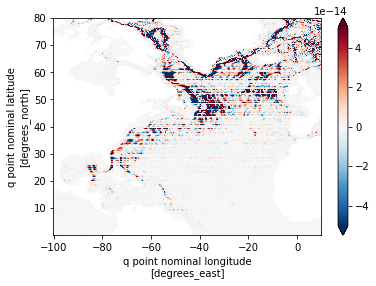

In [47]:
(BPT_2 - BPT['BPT']).plot(vmin=-5.e-14,vmax=5.e-14,cmap='RdBu_r')

#### Compute all terms

In [27]:
# area-weighted interpolation prefer
Mass_Surf = (grid.interp(grid.interp(ds['wfo'] * ds_grid['areacello'], 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'] / (rho_0)) / ds_grid['areacello_bu']
Mass_Surf = Mass_Surf.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

%time BPT['Qm'] = - Mass_Surf.load()

dhdt = (grid.interp(grid.interp(ds['zos'] * ds_grid['areacello'], 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis']) / ds_grid['areacello_bu']
dhdt = dhdt.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

%time BPT['fdhdt'] = dhdt.load()

div_u = (grid.diff(ds['umo'] / (rho_0), 'X', boundary='fill') + 
         grid.diff(ds['vmo'] / (rho_0), 'Y', boundary='fill') ) / ds_grid['areacello']
div_u = - (grid.interp(grid.interp(div_u * ds_grid['areacello'], 'X', boundary='fill'), 'Y', boundary='fill')
        * ds['Coriolis']) / ds_grid['areacello_bu'] 
%time BPT['div_u'] = div_u.load()

Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * colh_u * ds_grid['dxCu'], 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * colh_v * ds_grid['dyCv'], 'X', boundary='fill') ) / ds_grid.areacello_bu 
%time BPT['Curl_dudt'] = (Curl_dudt.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taus = ( - grid.diff((ds['taux'])* ds_grid.dxCu, 'Y', boundary='fill')
                   + grid.diff((ds['tauy'])* ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
Curl_taus = Curl_taus / (rho_0 )
%time BPT['Curl_taus'] = (Curl_taus.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds_grid.dxCu, 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
Curl_taub = Curl_taub / (rho_0 )
%time BPT['Curl_taub'] = (Curl_taub.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hrv2 = ( - grid.diff((ds['intz_rvxv_2d'] + ds['intz_gKEu_2d']) * ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_rvxu_2d'] + ds['intz_gKEv_2d']) * ds_grid.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
%time BPT['Curl_NL'] = (Curl_Hrv2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hdiff2 = ( - grid.diff(ds['intz_diffu_2d'] * ds_grid.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['intz_diffv_2d'] * ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
%time BPT['Curl_Hdiff'] = (Curl_Hdiff2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Cor2 = ( - grid.diff((ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d'])* ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d'])* ds_grid.dyCv, 'X', boundary='fill'))/ ds_grid.areacello_bu
%time BPT['Curl_Cor'] = (Curl_Cor2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

tmpx = (ds['hf_dudt_2d'] * colh_u - ds['intz_CAu_2d']-ds['intz_PFu_2d']-ds['intz_diffu_2d']-
       ds['intz_u_BT_accel_2d'] - ds['taux']/rho_0 + ds['taux_bot']/rho_0)
tmpy = (ds['hf_dvdt_2d'] * colh_v - ds['intz_CAv_2d']-ds['intz_PFv_2d']-ds['intz_diffv_2d']-
       ds['intz_v_BT_accel_2d'] - ds['tauy'] /rho_0 + ds['tauy_bot']/rho_0)
Curl_remap = ( - grid.diff(tmpx * ds_grid.dxCu, 'Y', boundary='fill')
             + grid.diff(tmpy * ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
%time BPT['Curl_remap'] = (Curl_remap.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

CPU times: user 6 ms, sys: 2 ms, total: 8 ms
Wall time: 7.38 ms
CPU times: user 4 ms, sys: 2 ms, total: 6 ms
Wall time: 5.81 ms
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.07 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.7 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.74 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 3.72 ms


#### Filter terms to remove noise

In [28]:
%%time

BPT_g = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT','Curl_taus','Curl_taub','Curl_NL', 'Curl_remap', 'Curl_Cor',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt', 'depth', 'fdhdt','div_u']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    dataBar = BPT[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds_grid['areacello_bu']

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'], NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'],dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds_grid['areacello_bu'] # divide by cell area    

    BPT_g[fld] = dataBar.copy()

CPU times: user 12.2 s, sys: 648 ms, total: 12.9 s
Wall time: 12.9 s


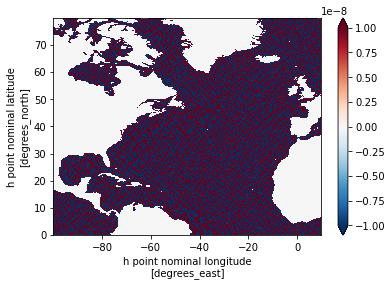

In [26]:
div_u = (grid.diff(ds['umo'] / (rho_0), 'X', boundary='fill')  + 
         grid.diff(ds['vmo'] / (rho_0), 'Y', boundary='fill') ) / ds_grid['areacello'] 

div_u.plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')

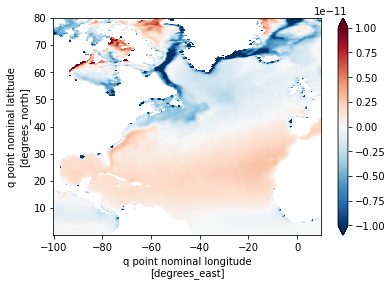

In [45]:
(BPT_g['Qm'] + BPT_g['fdhdt']).plot(vmin=-1e-11, vmax=1e-11, cmap='RdBu_r')

#### Plots

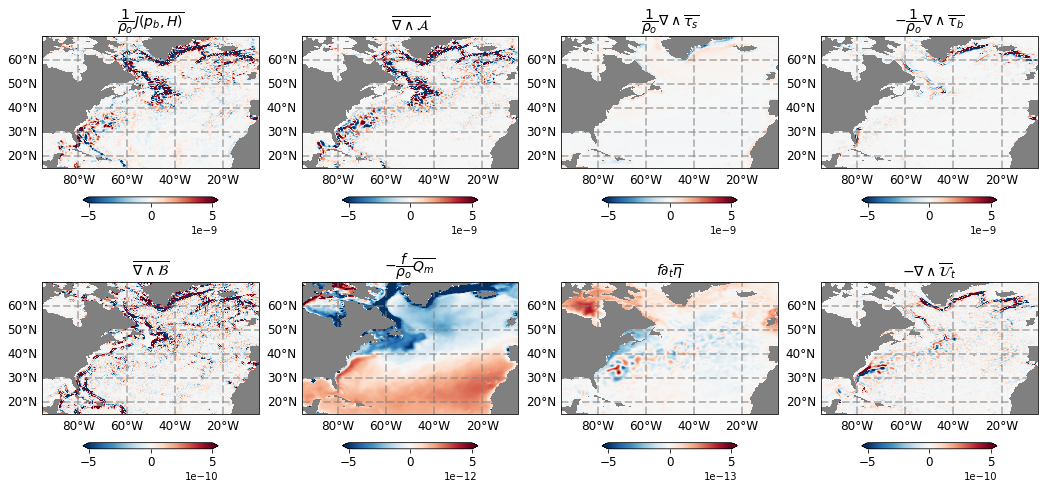

In [43]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(2, 4, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[18,8])

#ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
#_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
#                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta x \mathcal{V}$')

BPT1 = BPT_g['BPT'] + BPT_g['Curl_Cor'] + BPT_g['vmo_bv'] - BPT_g['Qm'] - BPT_g['fdhdt']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_NL'] + BPT_g['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Hdiff'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{B}}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Qm'], vmin=-0.001*max_r, vmax=0.001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \dfrac{f}{\rho_o}\overline{Q_m}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['fdhdt'], vmin=-0.0001*max_r, vmax=0.0001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ f\partial_t\overline{\eta}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t$')

#ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
#_ = plot_sec(ax, BPT1 + BPT_g['Curl_NL'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
#                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT + NL')

#tmp = (BPT1 + BPT_g['Curl_NL'] + BPT_g['Curl_remap'] + BPT_g['Qm'] + BPT_g['Curl_Hdiff'] + 
#       BPT_g['Curl_taub'] + BPT_g['Curl_taus'])
#ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
#im = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
#                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Sum all')

#cbar = fig.colorbar(im, ax=ax, shrink=0.95)
#plt.colorbar(format='%.1e', extend='both', shrink=0.6)

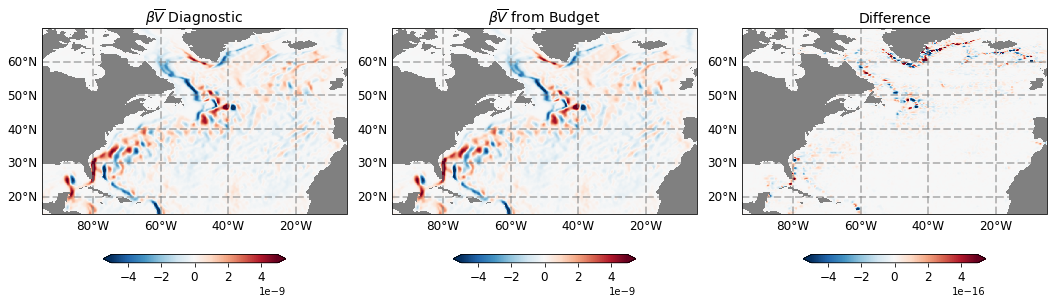

In [42]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.15)
fig = plt.figure(figsize=[18,5])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic')

tmp = (BPT1 + BPT_g['Curl_NL'] + BPT_g['Curl_remap'] + BPT_g['Curl_taus'] + BPT_g['Curl_taub'] +
      BPT_g['Curl_Hdiff'] + BPT_g['Qm'] + BPT_g['fdhdt'] - BPT_g['Curl_dudt'])
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ from Budget')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp - BPT_g['vmo_bv'], vmin=-1e-7*max_r, vmax=1e-7*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Difference')

# Laplacian steps: 42; # Biharmonic steps: 4


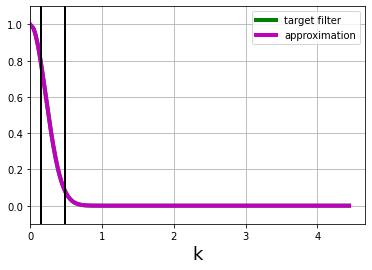

In [46]:
filter_fac = 16 # 1/8 --> 2 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 50
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

BPT_g1 = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT','Curl_taus','Curl_taub','Curl_NL', 'Curl_remap', 'Curl_Cor',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt', 'depth', 'fdhdt', 'div_u']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    dataBar = BPT[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds['areacello_bu']

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'], NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'],dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['areacello_bu'] # divide by cell area    

    BPT_g1[fld] = dataBar.copy()

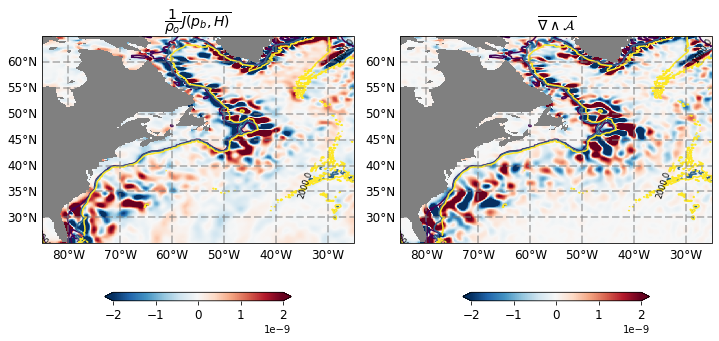

In [48]:
max_r = 2.e-9
lat_lon_ext = [-85., -25., 25., 65.]
#lat_lon_ext = [-65., -25., 45., 65.]

grid1 = plt.GridSpec(1, 2, wspace=0.15, hspace=0.15)
fig = plt.figure(figsize=[12,6])

BPT1 = BPT_g1['BPT'] + BPT_g1['Curl_Cor'] + BPT_g1['vmo_bv'] - BPT_g1['Qm'] - BPT_g1['fdhdt']
u = ds['umo'] / (ds.dyCu * colh_u * rho_0)

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

levels = [500., 1000., 2000.]
contours = plt.contour(ds.geolon_u, ds.geolat_u, depth_u, levels)
plt.clabel(contours, inline=True, fontsize=8, colors = 'k', fmt = '%4.1f')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g1['Curl_NL'] + BPT_g1['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

levels = [500., 1000., 2000.]
contours = plt.contour(ds.geolon_u, ds.geolat_u, depth_u, levels)
plt.clabel(contours, inline=True, fontsize=8, colors = 'k', fmt = '%4.1f')

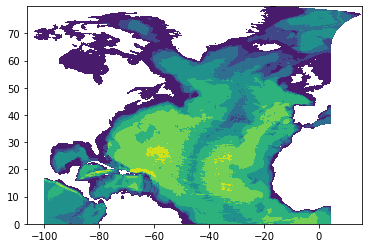

In [49]:
plt.contourf(ds.geolon_u, ds.geolat_u, depth_u)

In [100]:
ds.close()

### Testing with 5-yr average vs 50-yr average

In [5]:
import glob
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

client

<Client: 'tcp://127.0.0.1:41708' processes=4 threads=16, memory=406.01 GB>

### $1/8^{\circ}$ MOM6 data

In [6]:
path = "/archive/Hemant.Khatri/MOM_Budget/OM4p125/"

filelist = glob.glob(path + "OM4p125*.nc")
filelist.sort()

ds = []
for i in range(2,12):
    
    d = xr.open_dataset(filelist[i])
    ds.append(d)
    
ds = xr.concat(ds, dim='tim')
ds = ds.chunk({'tim': 1})

ds = ds.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

print(ds)

<xarray.Dataset>
Dimensions:             (tim: 10, xh: 835, xq: 835, yh: 964, yq: 964)
Coordinates:
  * xh                  (xh) float64 -99.93 -99.78 -99.63 ... 9.657 9.773 9.888
  * yh                  (yh) float64 0.0 0.125 0.25 0.375 ... 79.84 79.89 79.95
  * xq                  (xq) float64 -100.0 -99.85 -99.7 ... 9.657 9.773 9.888
  * yq                  (yq) float64 0.0625 0.1875 0.3125 ... 79.86 79.92 79.97
Dimensions without coordinates: tim
Data variables:
    hf_CAu_2d           (tim, yh, xq) float64 dask.array<chunksize=(1, 964, 835), meta=np.ndarray>
    hf_CAv_2d           (tim, yq, xh) float64 dask.array<chunksize=(1, 964, 835), meta=np.ndarray>
    hf_PFu_2d           (tim, yh, xq) float64 dask.array<chunksize=(1, 964, 835), meta=np.ndarray>
    hf_PFv_2d           (tim, yq, xh) float64 dask.array<chunksize=(1, 964, 835), meta=np.ndarray>
    hf_diffu_2d         (tim, yh, xq) float64 dask.array<chunksize=(1, 964, 835), meta=np.ndarray>
    hf_diffv_2d         (tim, yq, 

In [7]:
# Create grid and interpolate depth, beta

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

depth_u = grid.interp(ds['deptho'].isel(tim=0) * ds['areacello'].isel(tim=0), 'X',  boundary='fill')  / ds['areacello_cu'].isel(tim=0)
depth_v = grid.interp(ds['deptho'].isel(tim=0) * ds['areacello'].isel(tim=0), 'Y',  boundary='fill') / ds['areacello_cv'].isel(tim=0)
depth_q = grid.interp(depth_u * ds['areacello_cu'].isel(tim=0), 'Y',  boundary='fill') / ds['areacello_bu'].isel(tim=0)

colh_u = grid.interp(ds['col_height'] * ds['areacello'].isel(tim=0), 'X',  boundary='fill') / ds['areacello_cu'].isel(tim=0)
colh_v = grid.interp(ds['col_height'] * ds['areacello'].isel(tim=0), 'Y',  boundary='fill') / ds['areacello_cv'].isel(tim=0)

beta_v = 2*OMEGA*np.cos(ds.geolat_v.isel(tim=0) * np.pi /180.)/RAD_EARTH
beta_q = 2*OMEGA*np.cos(ds.geolat_c.isel(tim=0) * np.pi /180.)/RAD_EARTH

In [36]:
# compute terms in vorticity budget

rho_0 = 1035.

BPT = xr.Dataset()

vmo_bv = (ds['vmo'] / (rho_0 * ds['dxCv'].isel(tim=0)))
vmo_bv = beta_q * grid.interp(vmo_bv, 'X',  boundary='fill')
BPT['vmo_bv'] = vmo_bv

umo = (ds['umo'] / (rho_0 * ds['dyCu'].isel(tim=0)))
umo = grid.interp(umo, 'Y',  boundary='fill')
BPT['umo'] = umo

BPT_1 = (( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds.dyCv.isel(tim=0), 'X', boundary='fill')) 
         / ds.areacello_bu.isel(tim=0))
BPT['BPT'] = BPT_1

BPT['depth'] = (depth_q.load())

Mass_Surf = (grid.interp(grid.interp(ds['wfo'] * ds['areacello'].isel(tim=0), 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'].isel(tim=0) / (rho_0)) / ds['areacello_bu'].isel(tim=0)
BPT['Qm'] = Mass_Surf

dhdt = (grid.interp(grid.interp(ds['zos'] * ds['areacello'].isel(tim=0), 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'].isel(tim=0)) / ds['areacello_bu'].isel(tim=0)
BPT['fdhdt'] = dhdt

div_u = (grid.diff(ds['umo'] / (rho_0), 'X', boundary='fill') + 
         grid.diff(ds['vmo'] / (rho_0), 'Y', boundary='fill') ) / ds['areacello'].isel(tim=0)
div_u = - (grid.interp(grid.interp(div_u * ds['areacello'].isel(tim=0), 'X', boundary='fill'), 'Y', boundary='fill')
        * ds['Coriolis'].isel(tim=0)) / ds['areacello_bu'].isel(tim=0)
BPT['div_u'] = div_u

Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * colh_u * ds['dxCu'].isel(tim=0), 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * colh_v * ds['dyCv'].isel(tim=0), 'X', boundary='fill') ) / ds.areacello_bu.isel(tim=0)
BPT['Curl_dudt'] = Curl_dudt

Curl_taus = ( - grid.diff((ds['taux'])* ds.dxCu.isel(tim=0), 'Y', boundary='fill')
                   + grid.diff((ds['tauy'])* ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
Curl_taus = Curl_taus / (rho_0 )
BPT['Curl_taus'] = Curl_taus

Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds.dxCu.isel(tim=0), 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
Curl_taub = Curl_taub / (rho_0 )
BPT['Curl_taub'] = Curl_taub

Curl_Hrv2 = ( - grid.diff((ds['intz_rvxv_2d'] + ds['intz_gKEu_2d']) * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
           + grid.diff((ds['intz_rvxu_2d'] + ds['intz_gKEv_2d']) * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
BPT['Curl_NL'] = Curl_Hrv2

Curl_Hdiff2 = ( - grid.diff(ds['intz_diffu_2d'] * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
             + grid.diff(ds['intz_diffv_2d'] * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
BPT['Curl_Hdiff'] = Curl_Hdiff2

Curl_Cor2 = ( - grid.diff((ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d'])* ds.dxCu.isel(tim=0), 'Y', boundary='fill')
           + grid.diff((ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d'])* ds.dyCv.isel(tim=0), 'X', boundary='fill'))/ ds.areacello_bu.isel(tim=0)
BPT['Curl_Cor'] = Curl_Cor2

tmpx = (ds['hf_dudt_2d'] * colh_u - ds['intz_CAu_2d']-ds['intz_PFu_2d']-ds['intz_diffu_2d']-
       ds['intz_u_BT_accel_2d'] - ds['taux']/rho_0 + ds['taux_bot']/rho_0)
tmpy = (ds['hf_dvdt_2d'] * colh_v - ds['intz_CAv_2d']-ds['intz_PFv_2d']-ds['intz_diffv_2d']-
       ds['intz_v_BT_accel_2d'] - ds['tauy'] /rho_0 + ds['tauy_bot']/rho_0)
Curl_remap = ( - grid.diff(tmpx * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
             + grid.diff(tmpy * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
BPT['Curl_remap'] = Curl_remap

#### Filter 5-yr average and 50-year average 

In [ ]:
# Set Filter

# Guassian Filter set 

filter_fac = 16 # 1/8 --> 2 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 40
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

In [38]:
%%time

BPT_g_5 = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT','Curl_taus','Curl_taub','Curl_NL', 'Curl_remap', 'Curl_Cor',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt', 'depth', 'fdhdt','div_u', 'umo']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    if(fld == 'depth'):
        dataBar = BPT[fld].load().copy() # Initialize the filtering process
    else:
        dataBar = BPT[fld].isel(tim=0).load().copy()
        
    dataBar = dataBar * ds['areacello_bu'].isel(tim=0).load()

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'].isel(tim=0).load(), NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'].isel(tim=0).load(),dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['areacello_bu'].isel(tim=0) # divide by cell area    

    BPT_g_5[fld] = (dataBar.copy()).assign_coords({'geolat_c': ds['geolat_c'].isel(tim=0), 
                                                   'geolon_c': ds['geolon_c'].isel(tim=0)})

CPU times: user 8.32 s, sys: 3.57 s, total: 11.9 s
Wall time: 13.1 s


In [39]:
%%time

BPT_g_50 = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT','Curl_taus','Curl_taub','Curl_NL', 'Curl_remap', 'Curl_Cor',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt', 'depth', 'fdhdt','div_u', 'umo']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    if(fld == 'depth'):
        dataBar = BPT[fld].load().copy() # Initialize the filtering process
    else:
        dataBar = BPT[fld].mean('tim').load().copy()
        
    dataBar = dataBar * ds['areacello_bu'].isel(tim=0).load()

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'].isel(tim=0).load(), NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'].isel(tim=0).load(),dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['areacello_bu'].isel(tim=0) # divide by cell area    

    BPT_g_50[fld] = (dataBar.copy()).assign_coords({'geolat_c': ds['geolat_c'].isel(tim=0), 
                                                   'geolon_c': ds['geolon_c'].isel(tim=0)})

CPU times: user 15.9 s, sys: 23.8 s, total: 39.7 s
Wall time: 42.8 s


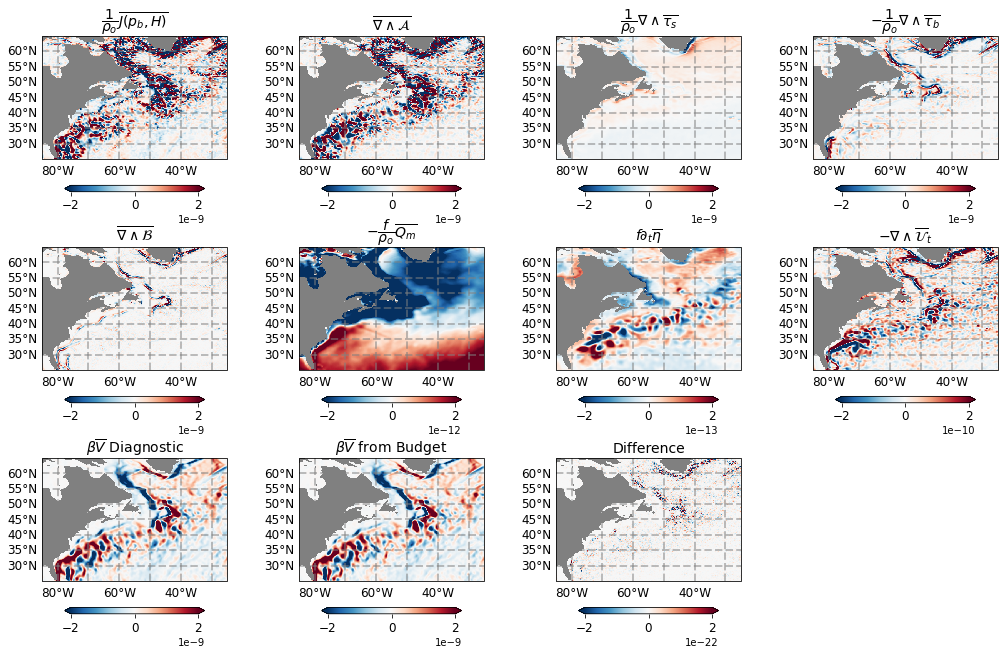

In [40]:
# 5-yr average plot

max_r = 2.e-9
#lat_lon_ext = [-95., -5., 15., 70.]
lat_lon_ext = [-85., -25., 25., 65.]

grid1 = plt.GridSpec(3, 4, wspace=0.1, hspace=0.2)
fig = plt.figure(figsize=[18,11])

BPT_g = BPT_g_5

BPT1 = BPT_g['BPT'] + BPT_g['Curl_Cor'] + BPT_g['vmo_bv'] + BPT_g['Qm'] - BPT_g['fdhdt']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_NL'] + BPT_g['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Hdiff'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{B}}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Qm'], vmin=-0.001*max_r, vmax=0.001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \dfrac{f}{\rho_o}\overline{Q_m}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['fdhdt'], vmin=-0.0001*max_r, vmax=0.0001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ f\partial_t\overline{\eta}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t$')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic')

tmp = (BPT1 + BPT_g['Curl_NL'] + BPT_g['Curl_remap'] + BPT_g['Curl_taus'] + BPT_g['Curl_taub'] +
      BPT_g['Curl_Hdiff'] - BPT_g['Qm'] + BPT_g['fdhdt'] - BPT_g['Curl_dudt'])
ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ from Budget')

ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp - BPT_g['vmo_bv'], vmin=-1e-13*max_r, vmax=1e-13*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Difference')

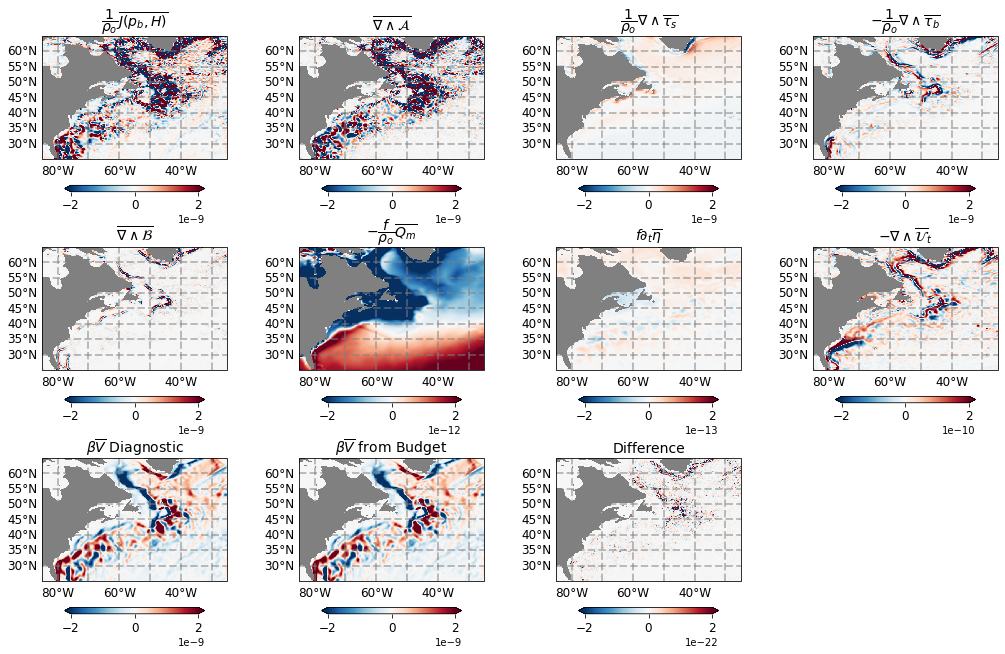

In [27]:
# 50-yr average plot

max_r = 2.e-9
#lat_lon_ext = [-95., -5., 15., 70.]
lat_lon_ext = [-85., -25., 25., 65.]

grid1 = plt.GridSpec(3, 4, wspace=0.1, hspace=0.2)
fig = plt.figure(figsize=[18,11])

BPT_g = BPT_g_50

BPT1 = BPT_g['BPT'] + BPT_g['Curl_Cor'] + BPT_g['vmo_bv'] + BPT_g['Qm'] - BPT_g['fdhdt']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_NL'] + BPT_g['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Hdiff'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{B}}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Qm'], vmin=-0.001*max_r, vmax=0.001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \dfrac{f}{\rho_o}\overline{Q_m}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['fdhdt'], vmin=-0.0001*max_r, vmax=0.0001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ f\partial_t\overline{\eta}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t$')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic')

tmp = (BPT1 + BPT_g['Curl_NL'] + BPT_g['Curl_remap'] + BPT_g['Curl_taus'] + BPT_g['Curl_taub'] +
      BPT_g['Curl_Hdiff'] - BPT_g['Qm'] + BPT_g['fdhdt'] - BPT_g['Curl_dudt'])
ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ from Budget')

ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp - BPT_g['vmo_bv'], vmin=-1e-13*max_r, vmax=1e-13*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Difference')

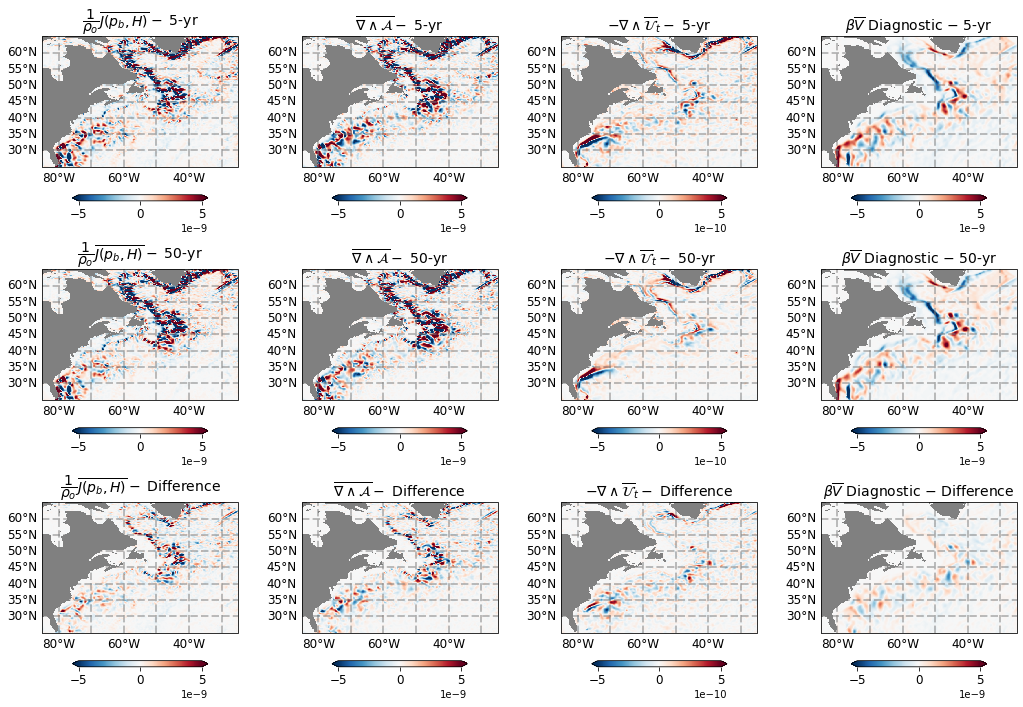

In [35]:
# BPT, NL, du/dt terms compare 5-yr and 50-yr averages

max_r = 5.e-9
#lat_lon_ext = [-95., -5., 15., 70.]
lat_lon_ext = [-85., -25., 25., 65.]

grid1 = plt.GridSpec(3, 4, wspace=0.15, hspace=0.25)
fig = plt.figure(figsize=[18,12])

BPT_5 = BPT_g_5['BPT'] + BPT_g_5['Curl_Cor'] + BPT_g_5['vmo_bv'] + BPT_g_5['Qm'] - BPT_g_5['fdhdt']
BPT_50 = BPT_g_50['BPT'] + BPT_g_50['Curl_Cor'] + BPT_g_50['vmo_bv'] + BPT_g_50['Qm'] - BPT_g_50['fdhdt']

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_5, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)} -$ 5-yr')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_50, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)} -$ 50-yr')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_5 - BPT_50, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)} -$ Difference')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_5['Curl_NL'] + BPT_g_5['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}} -$ 5-yr')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_50['Curl_NL'] + BPT_g_50['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}} -$ 50-yr')

ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_5['Curl_NL'] + BPT_g_5['Curl_remap'] - BPT_g_50['Curl_NL'] - BPT_g_50['Curl_remap'], vmin=-max_r, 
             vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}} -$ Difference')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g_5['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t -$ 5-yr')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g_50['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t -$ 50-yr')

ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g_5['Curl_dudt'] + BPT_g_50['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t -$ Difference')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_5['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic $-$ 5-yr')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_50['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic $-$ 50-yr')

ax = fig.add_subplot(grid1[2, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_5['vmo_bv'] - BPT_g_50['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic $-$ Difference')

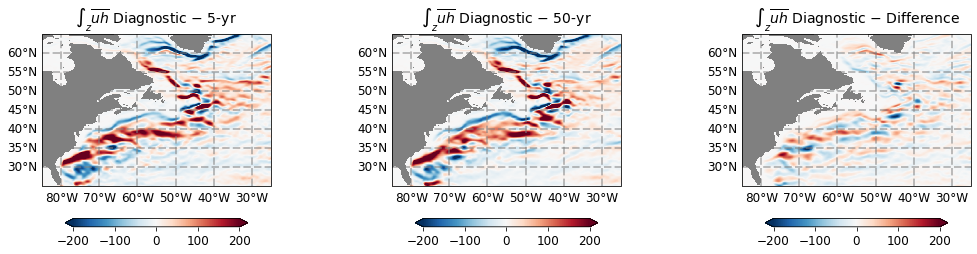

In [45]:
max_r = 200.
lat_lon_ext = [-85., -25., 25., 65.]

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.25)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_5['umo'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\int_z\overline{uh}$ Diagnostic $-$ 5-yr')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_50['umo'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\int_z\overline{uh}$ Diagnostic $-$ 50-yr')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g_5['umo'] - BPT_g_50['umo'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\int_z\overline{uh}$ Diagnostic $-$ Difference')

### $1/4^{\circ}$ MOM6 data

In [5]:
path = "/archive/Hemant.Khatri/MOM_Budget/OM4p25/"

filelist = glob.glob(path + "OM4p25*.nc")
filelist.sort()

ds = []
for i in range(2,12):
    
    d = xr.open_dataset(filelist[i])
    ds.append(d)
    
ds = xr.concat(ds, dim='tim')
ds = ds.chunk({'tim': 1})

ds = ds.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

print(ds)

<xarray.Dataset>
Dimensions:             (tim: 10, xh: 438, xq: 438, yh: 484, yq: 484)
Coordinates:
  * xh                  (xh) float64 -99.87 -99.62 -99.36 ... 9.453 9.701 9.949
  * yh                  (yh) float64 0.0 0.25 0.5 0.75 ... 79.68 79.79 79.89
  * xq                  (xq) float64 -100.0 -99.75 -99.49 ... 9.352 9.599 9.847
  * yq                  (yq) float64 0.125 0.375 0.625 ... 79.73 79.84 79.95
Dimensions without coordinates: tim
Data variables:
    hf_CAu_2d           (tim, yh, xq) float64 dask.array<chunksize=(1, 484, 438), meta=np.ndarray>
    hf_CAv_2d           (tim, yq, xh) float64 dask.array<chunksize=(1, 484, 438), meta=np.ndarray>
    hf_PFu_2d           (tim, yh, xq) float64 dask.array<chunksize=(1, 484, 438), meta=np.ndarray>
    hf_PFv_2d           (tim, yq, xh) float64 dask.array<chunksize=(1, 484, 438), meta=np.ndarray>
    hf_diffu_2d         (tim, yh, xq) float64 dask.array<chunksize=(1, 484, 438), meta=np.ndarray>
    hf_diffv_2d         (tim, yq, xh) f

In [6]:
# Create grid and interpolate depth, beta

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

depth_u = grid.interp(ds['deptho'].isel(tim=0) * ds['areacello'].isel(tim=0), 'X',  boundary='fill')  / ds['areacello_cu'].isel(tim=0)
depth_v = grid.interp(ds['deptho'].isel(tim=0) * ds['areacello'].isel(tim=0), 'Y',  boundary='fill') / ds['areacello_cv'].isel(tim=0)
depth_q = grid.interp(depth_u * ds['areacello_cu'].isel(tim=0), 'Y',  boundary='fill') / ds['areacello_bu'].isel(tim=0)

colh_u = grid.interp(ds['col_height'] * ds['areacello'].isel(tim=0), 'X',  boundary='fill') / ds['areacello_cu'].isel(tim=0)
colh_v = grid.interp(ds['col_height'] * ds['areacello'].isel(tim=0), 'Y',  boundary='fill') / ds['areacello_cv'].isel(tim=0)

beta_v = 2*OMEGA*np.cos(ds.geolat_v.isel(tim=0) * np.pi /180.)/RAD_EARTH
beta_q = 2*OMEGA*np.cos(ds.geolat_c.isel(tim=0) * np.pi /180.)/RAD_EARTH

In [7]:
# compute terms in vorticity budget

rho_0 = 1035.

BPT = xr.Dataset()

vmo_bv = (ds['vmo'] / (rho_0 * ds['dxCv'].isel(tim=0)))
vmo_bv = beta_q * grid.interp(vmo_bv, 'X',  boundary='fill')
BPT['vmo_bv'] = vmo_bv

umo = (ds['umo'] / (rho_0 * ds['dyCu'].isel(tim=0)))
umo = grid.interp(umo, 'Y',  boundary='fill')
BPT['umo'] = umo

BPT_1 = (( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds.dyCv.isel(tim=0), 'X', boundary='fill')) 
         / ds.areacello_bu.isel(tim=0))
BPT['BPT'] = BPT_1

BPT['depth'] = (depth_q.load())

Mass_Surf = (grid.interp(grid.interp(ds['wfo'] * ds['areacello'].isel(tim=0), 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'].isel(tim=0) / (rho_0)) / ds['areacello_bu'].isel(tim=0)
BPT['Qm'] = Mass_Surf

dhdt = (grid.interp(grid.interp(ds['zos'] * ds['areacello'].isel(tim=0), 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'].isel(tim=0)) / ds['areacello_bu'].isel(tim=0)
BPT['fdhdt'] = dhdt

div_u = (grid.diff(ds['umo'] / (rho_0), 'X', boundary='fill') + 
         grid.diff(ds['vmo'] / (rho_0), 'Y', boundary='fill') ) / ds['areacello'].isel(tim=0)
div_u = - (grid.interp(grid.interp(div_u * ds['areacello'].isel(tim=0), 'X', boundary='fill'), 'Y', boundary='fill')
        * ds['Coriolis'].isel(tim=0)) / ds['areacello_bu'].isel(tim=0)
BPT['div_u'] = div_u

Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * colh_u * ds['dxCu'].isel(tim=0), 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * colh_v * ds['dyCv'].isel(tim=0), 'X', boundary='fill') ) / ds.areacello_bu.isel(tim=0)
BPT['Curl_dudt'] = Curl_dudt

Curl_taus = ( - grid.diff((ds['taux'])* ds.dxCu.isel(tim=0), 'Y', boundary='fill')
                   + grid.diff((ds['tauy'])* ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
Curl_taus = Curl_taus / (rho_0 )
BPT['Curl_taus'] = Curl_taus

Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds.dxCu.isel(tim=0), 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
Curl_taub = Curl_taub / (rho_0 )
BPT['Curl_taub'] = Curl_taub

Curl_Hrv2 = ( - grid.diff((ds['intz_rvxv_2d'] + ds['intz_gKEu_2d']) * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
           + grid.diff((ds['intz_rvxu_2d'] + ds['intz_gKEv_2d']) * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
BPT['Curl_NL'] = Curl_Hrv2

Curl_Hdiff2 = ( - grid.diff(ds['intz_diffu_2d'] * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
             + grid.diff(ds['intz_diffv_2d'] * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
BPT['Curl_Hdiff'] = Curl_Hdiff2

Curl_Cor2 = ( - grid.diff((ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d'])* ds.dxCu.isel(tim=0), 'Y', boundary='fill')
           + grid.diff((ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d'])* ds.dyCv.isel(tim=0), 'X', boundary='fill'))/ ds.areacello_bu.isel(tim=0)
BPT['Curl_Cor'] = Curl_Cor2

tmpx = (ds['hf_dudt_2d'] * colh_u - ds['intz_CAu_2d']-ds['intz_PFu_2d']-ds['intz_diffu_2d']-
       ds['intz_u_BT_accel_2d'] - ds['taux']/rho_0 + ds['taux_bot']/rho_0)
tmpy = (ds['hf_dvdt_2d'] * colh_v - ds['intz_CAv_2d']-ds['intz_PFv_2d']-ds['intz_diffv_2d']-
       ds['intz_v_BT_accel_2d'] - ds['tauy'] /rho_0 + ds['tauy_bot']/rho_0)
Curl_remap = ( - grid.diff(tmpx * ds.dxCu.isel(tim=0), 'Y', boundary='fill')
             + grid.diff(tmpy * ds.dyCv.isel(tim=0), 'X', boundary='fill') )/ ds.areacello_bu.isel(tim=0) 
BPT['Curl_remap'] = Curl_remap

# Laplacian steps: 16; # Biharmonic steps: 2


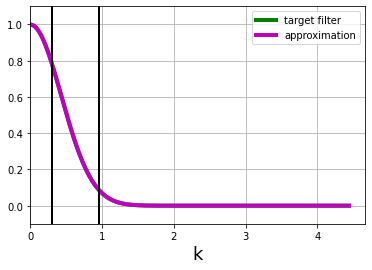

In [8]:
# Set Filter

# Guassian Filter set 

filter_fac = 8 # 1/4 --> 2 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 20
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

In [9]:
%%time

BPT_g_50 = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT','Curl_taus','Curl_taub','Curl_NL', 'Curl_remap', 'Curl_Cor',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt', 'depth', 'fdhdt','div_u', 'umo']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    if(fld == 'depth'):
        dataBar = BPT[fld].load().copy() # Initialize the filtering process
    else:
        dataBar = BPT[fld].mean('tim').load().copy()
        
    dataBar = dataBar * ds['areacello_bu'].isel(tim=0).load()

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'].isel(tim=0).load(), NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'].isel(tim=0).load(),dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['areacello_bu'].isel(tim=0) # divide by cell area    

    BPT_g_50[fld] = (dataBar.copy()).assign_coords({'geolat_c': ds['geolat_c'].isel(tim=0), 
                                                   'geolon_c': ds['geolon_c'].isel(tim=0)})

CPU times: user 3.31 s, sys: 713 ms, total: 4.02 s
Wall time: 2.76 s


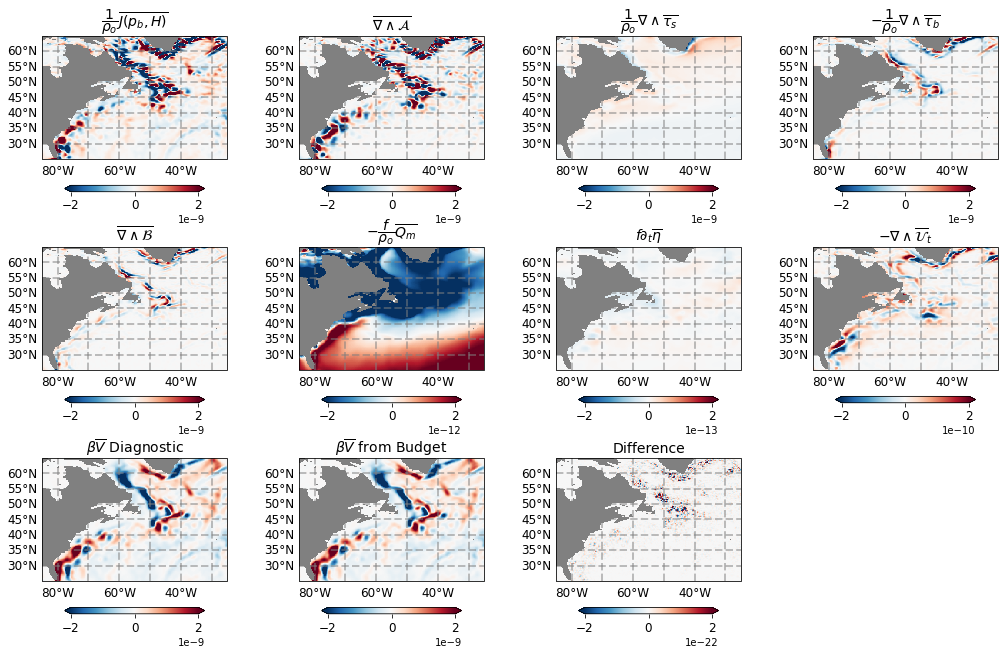

In [10]:
# 50-yr average plot

max_r = 2.e-9
#lat_lon_ext = [-95., -5., 15., 70.]
lat_lon_ext = [-85., -25., 25., 65.]

grid1 = plt.GridSpec(3, 4, wspace=0.1, hspace=0.2)
fig = plt.figure(figsize=[18,11])

BPT_g = BPT_g_50

BPT1 = BPT_g['BPT'] + BPT_g['Curl_Cor'] + BPT_g['vmo_bv'] + BPT_g['Qm'] - BPT_g['fdhdt']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_NL'] + BPT_g['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Hdiff'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{B}}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Qm'], vmin=-0.001*max_r, vmax=0.001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \dfrac{f}{\rho_o}\overline{Q_m}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['fdhdt'], vmin=-0.0001*max_r, vmax=0.0001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ f\partial_t\overline{\eta}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t$')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic')

tmp = (BPT1 + BPT_g['Curl_NL'] + BPT_g['Curl_remap'] + BPT_g['Curl_taus'] + BPT_g['Curl_taub'] +
      BPT_g['Curl_Hdiff'] - BPT_g['Qm'] + BPT_g['fdhdt'] - BPT_g['Curl_dudt'])
ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ from Budget')

ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp - BPT_g['vmo_bv'], vmin=-1e-13*max_r, vmax=1e-13*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Difference')

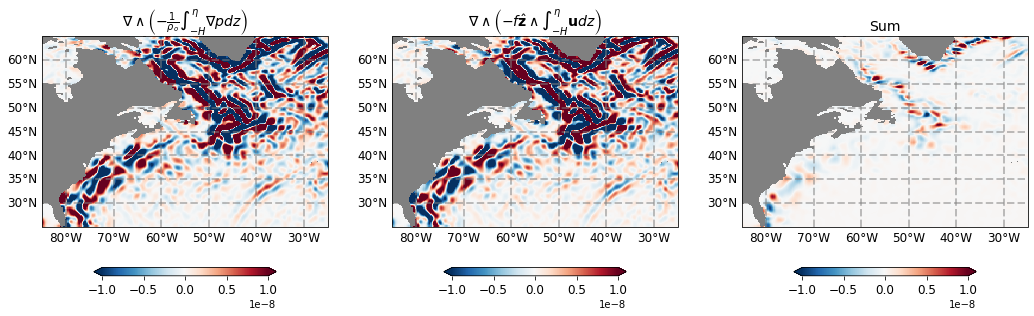

In [12]:
max_r = 1.e-8
lat_lon_ext = [-85., -25., 25., 65.]

BPT_g = BPT_g_50

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.25)
fig = plt.figure(figsize=[18,5])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\nabla \wedge \left( - \frac{1}{\rho_o}\int_{-H}^{\eta} \nabla pdz \right)$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Cor'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\nabla \wedge\left(- f \hat{{\bf z}} \wedge \int_{-H}^{\eta} \mathbf{u}dz \right)$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Cor'] + BPT_g['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Sum')

In [13]:
#client.close()
#cluster.close()
ds.close()